In [10]:
import torch
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import optim
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import math

In [11]:
x_data_ = pd.read_csv("../python-docker/Swedbank_A/x_Swedbank_A_100_p.csv", sep=";", usecols = [i for i in range(100)])

In [12]:
rsi = pd.read_csv("../python-docker/Swedbank_A/x_Swedbank_A_rsi.csv", sep=";", usecols=["Swedbank_Arsi"])

In [13]:
macd = pd.read_csv("../python-docker/Swedbank_A/x_Swedbank_A_macd.csv", sep=";", usecols=["Swedbank_Amacd"])

In [14]:
y_data = pd.read_csv("../python-docker/Swedbank_A/y_Swedbank_A_100.csv", sep=";")

In [15]:
y_data.head()

,15s,15ud,30s,30ud,60s,60ud,300s,300ud,600s,600ud,ts
0,144.46,0,144.32,0,144.20,0,144.10,0,144.32,0,1598425200
1,144.46,0,144.32,0,144.20,0,144.22,0,144.32,0,1598425201
2,144.46,0,144.32,0,144.20,0,144.26,0,144.32,0,1598425202
3,144.46,0,144.32,0,144.12,0,144.26,0,144.32,0,1598425203
4,144.46,0,144.32,0,144.12,0,144.26,0,144.32,0,1598425204


In [16]:
print(x_data_.shape)
x_data__ = x_data_.join(rsi)
x_data = x_data__.join(macd)
print(x_data.shape)
x_data.head()

(3242927, 100)
(3242927, 102)


,Swedbank_A-price-0,Swedbank_A-price-1,Swedbank_A-price-2,Swedbank_A-price-3,Swedbank_A-price-4,Swedbank_A-price-5,Swedbank_A-price-6,Swedbank_A-price-7,Swedbank_A-price-8,Swedbank_A-price-9,...,Swedbank_A-price-92,Swedbank_A-price-93,Swedbank_A-price-94,Swedbank_A-price-95,Swedbank_A-price-96,Swedbank_A-price-97,Swedbank_A-price-98,Swedbank_A-price-99,Swedbank_Arsi,Swedbank_Amacd
0,144.5,144.5,144.5,144.5,144.5,144.5,144.5,144.5,144.5,144.5,...,144.5,144.5,144.5,144.5,144.5,144.5,144.5,144.5,37.2882,0.0
1,144.5,144.5,144.5,144.5,144.5,144.5,144.5,144.5,144.5,144.5,...,144.5,144.5,144.5,144.5,144.5,144.5,144.5,144.5,37.2882,0.0
2,144.5,144.5,144.5,144.5,144.5,144.5,144.5,144.5,144.5,144.5,...,144.5,144.5,144.5,144.5,144.5,144.5,144.5,144.5,37.2882,0.0
3,144.5,144.5,144.5,144.5,144.5,144.5,144.5,144.5,144.5,144.5,...,144.5,144.5,144.5,144.5,144.5,144.5,144.5,144.5,37.2882,0.0
4,144.5,144.5,144.5,144.5,144.5,144.5,144.5,144.5,144.5,144.5,...,144.5,144.5,144.5,144.5,144.5,144.5,144.5,144.5,37.2882,0.0


In [18]:
y_data = y_data["15s"]
y_data.shape

KeyError: '15s'

In [21]:
def splitData(xs, ys, trainRatio):
    t = round(len(xs)*trainRatio)
    
    train_data_x = torch.tensor(xs[:t].values, dtype=torch.float32)
    train_data_y = torch.tensor(ys[:t].values, dtype=torch.float32)
    
    d = round(len(xs[t:])/2)
    
    dev_data_x = torch.tensor(xs[t:][:d].values, dtype=torch.float32)
    dev_data_y = torch.tensor(ys[t:][:d].values, dtype=torch.float32)
    
    test_data_x = torch.tensor(xs[t:][d:].values, dtype=torch.float32)
    test_data_y = torch.tensor(ys[t:][d:].values, dtype=torch.float32)
    
    #print(test_data_y.shape)
    
    return TensorDataset(train_data_x, train_data_y), TensorDataset(dev_data_x, dev_data_y), list(zip(test_data_x, test_data_y))

In [22]:
train_data, dev_data, test_data = splitData(x_data, y_data, 0.8)

In [23]:
input_size=102
batch_size=256
nbr_epochs=7

In [24]:
#compute_unit = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device('cuda:0')
#device = torch.device("cpu")
#compute_unit = "cpu"

In [25]:
#dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor # Uncomment this to run on GPU

In [26]:
class StockModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 150).type(dtype)
        nn.init.normal_(self.fc1.weight, mean=0, std=1)
        self.fc1.weight = nn.Parameter(self.fc1.weight * math.sqrt(2/input_size))
        self.fc2 = nn.Linear(150, 100).type(dtype)
        nn.init.normal_(self.fc2.weight, mean=0, std=1)
        self.fc2.weight = nn.Parameter(self.fc2.weight * math.sqrt(2/input_size))
        self.fc3 = nn.Linear(100, 30).type(dtype)
        nn.init.normal_(self.fc3.weight, mean=0, std=1)
        self.fc3.weight = nn.Parameter(self.fc3.weight * math.sqrt(2/input_size))
        self.fc4 = nn.Linear(30, 10).type(dtype)
        nn.init.normal_(self.fc4.weight, mean=0, std=1)
        self.fc4.weight = nn.Parameter(self.fc4.weight * math.sqrt(2/input_size))
        self.fc5 = nn.Linear(10, 1).type(dtype)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return F.relu(self.fc5(x))
    
model = StockModel(input_size)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [27]:
def evaluate_model(data, model, loss_fn):
    losses = []
    predictions = []
    with torch.no_grad():
        for x, y in data:
            y = y.squeeze().type(dtype)
            x = x.squeeze().type(dtype)
            pred = model(x)
            loss = loss_fn(pred, y)
            losses.append(loss.item())
            predictions.extend(pred.tolist())
        avg_loss = sum(losses)/len(losses)    
    
    return avg_loss, predictions

In [28]:
def train_model(model, train_data_loader, dev_data_loader, loss_fn, optimizer, epochrange, batchsize):
    for epoch in range(epochrange):
        losses = []
        n_correct = 0
        for x, y in train_data_loader:
            y = y.type(dtype)
            x = x.type(dtype)
            pred = model(x)
            
            loss = loss_fn(pred, y)
            
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()    

        # Compute accuracy and loss in the entire training set
        train_avg_loss = sum(losses)/len(losses)    
        
        dev_avg_loss,_ = evaluate_model(dev_data_loader, model, loss_fn)
        
        # Display metrics
        display_str = 'Epoch {} '
        display_str += '\tLoss: {:.3f} '
        display_str += '\tLoss (val): {:.3f}'
        print(display_str.format(epoch, train_avg_loss, dev_avg_loss))

In [29]:
train_data_loader = DataLoader(train_data, batch_size=batch_size)
dev_data_loader = DataLoader(dev_data, batch_size=batch_size)

In [30]:
model = model.to(device)
train_model(model, train_data_loader, dev_data_loader, loss_fn, optimizer, nbr_epochs, batch_size)

C:\Users\kajen\.conda\envs\titantesttest\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\kajen\.conda\envs\titantesttest\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([38])) that is different to the input size (torch.Size([38, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\kajen\.conda\envs\titantesttest\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([196])) that is different to the input size (torch.Size([196, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Epoch 0 	Loss: 6.750 	Loss (val): 0.044
Epoch 1 	Loss: 0.117 	Loss (val): 0.125
Epoch 2 	Loss: 0.108 	Loss (val): 0.194
Epoch 3 	Loss: 0.179 	Loss (val): 0.127
Epoch 4 	Loss: 0.163 	Loss (val): 0.158
Epoch 5 	Loss: 0.131 	Loss (val): 0.037
Epoch 6 	Loss: 0.106 	Loss (val): 0.090


In [31]:
_, preds = evaluate_model(test_data, model, loss_fn)

C:\Users\kajen\.conda\envs\titantesttest\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


153.37960815429688


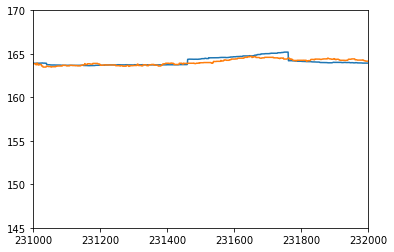

In [36]:
y_data_borpi = list(zip(*test_data))
print(preds[0])
items_plot = [y_data_borpi[1][t] for t in range(len(y_data_borpi[1]))]
plt.plot(list(range(len(preds))), preds)
plt.plot(list(range(len(items_plot))), items_plot)
axes = plt.gca()
axes.set_ylim([145,170])
axes.set_xlim([231000,232000])
plt.show()